In [1]:
import os
import numpy as np
import torch
from radioNN.data.loader import AntennaDataset
from radioNN.data.transforms import sph2cart, cart2sph
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from radioNN.process_network import NetworkProcess
from radioNN.networks.antenna_fc_network import AntennaNetworkFC
from view_scalars import thin_or_not
plt.rcParams['axes.formatter.use_mathtext'] = True
radio_data_path = "/home/pranav/work-stuff-unsynced/radio_data"
input_data_file = os.path.join(radio_data_path, "input_data.npy")
input_meta_file = os.path.join(radio_data_path, "meta_data.npy")
antenna_pos_file = os.path.join(radio_data_path, "antenna_pos_data.npy")
output_meta_file = os.path.join(radio_data_path, "output_meta_data.npy")
#output_file = os.path.join(radio_data_path, "output_gece_data.npy")
output_file = os.path.join(radio_data_path, "output_vBvvB_data.npy")
dataset = AntennaDataset(
    input_data_file,
    input_meta_file,
    antenna_pos_file,
    output_meta_file,
    output_file,
    mmap_mode='r',
    one_shower=33,
    # return_fluence=False,
    # percentage=0.01,
)
process = NetworkProcess(
    model_class=AntennaNetworkFC,
    # one_shower=one_shower,
    percentage=0.01,
    batch_size=8,
    wb=False,
)

def make_table(input_meta):
    """
    Meta Data format:
    index 0: Sim number
    index 1: Cos(Zenith Angle)
    index 2: X_max
    index 3: density at X_max
    index 4: height at X_max
    index 5: E_em
    index 6: sin(geomagnetic_angle)
    index 7: B inclination
    index 8: B declination
    index 9: B strength
    index 10: primary particle
    index 11: primary energy
    index 12: Azimuthal angle
    """
    return {
        "Sim number": input_meta[0],
        "Zenith": np.rad2deg(np.arccos(input_meta[1])),
        "X_max": input_meta[2]*700,
        "density at X_max": input_meta[3],
        "height at X_max": input_meta[4]*700*1e3,
        "E_em": np.exp(input_meta[5]*20),
        "sin(geomagnetic_angle)": input_meta[6],
        "B inclination": input_meta[7],
        "B declination": input_meta[8],
        "B strength": input_meta[9],
        "primary particle": input_meta[10],
        "primary energy": np.exp(input_meta[11]),
        "Azimuth": np.rad2deg(input_meta[12]),
    }

/home/pranav/.conda/envs/pytorch3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using the data from /home/pranav/work-stuff-unsynced/radio_data in cpu with memmap mode: r using 0.01% of data
Total showers after filter 58185


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 552.11it/s]

2
Using <class 'radioNN.networks.antenna_fc_network.AntennaNetworkFC'>


In [6]:
#model_name = "2309Sep26Tue_155429"
#model_name = "2405May14Tue_172854"
#model_name = "2405May18Sat_030851"
model_name = "2405May24Fri_145354" #awesome model
#model_name = "2406Jun10Mon_144306"
#model_name = "2406Jun20Thu_200714"
#model_name = "2406Jun29Sat_171314"

process.output_channels = 2


#model_name = "2408Aug09Fri_044909"
process.model = AntennaNetworkFC(2)
BASE_PATH = "/home/pranav/MEGA/work-stuff/radio_nn/runs"
if not os.path.isfile(f"{BASE_PATH}/{model_name}/SavedState"):
    BASE_PATH = "/home/pranav/work-stuff-unsynced/old_network_runs"
state_checkpoint = torch.load(
    f"{BASE_PATH}/{model_name}/SavedState",
)
process.model.load_state_dict(state_checkpoint['model_state_dict'])
process.model.eval()

RuntimeError: Error(s) in loading state_dict for AntennaNetworkFC:
	size mismatch for fc_layers_decode.6.weight: copying a param with shape torch.Size([768, 1024]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for fc_layers_decode.6.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([512]).

In [41]:
def footprint(real, pos, meta, sim, inp_meta, index=0, radius=np.inf):
    if index == 0:
        from view_scalars import get_fluences0 as sc_fn
    elif index == 1:
        from view_scalars import get_fluences1 as sc_fn
    elif index == 2:
        from view_scalars import thin_or_not as sc_fn
    else:
        from view_scalars import get_polarity as sc_fn
    from view_scalars import thin_or_not
    scalar = sc_fn(real, pos, meta)
    from scipy.interpolate import RBFInterpolator
    fig, ax = plt.subplot_mosaic("AB", figsize=(12, 10), gridspec_kw={"width_ratios": [90, 10]})
    x_pos = pos[:, 0]
    y_pos = pos[:, 1]
    xs = np.linspace(np.nanmin(x_pos), np.nanmax(x_pos), 100)
    ys = np.linspace(np.nanmin(y_pos), np.nanmax(y_pos), 100)
    xx, yy = np.meshgrid(xs, ys)
    # points within a circle
    in_star = np.array(xx**2 + yy**2 <= np.nanmax(x_pos**2 + y_pos**2))
    interp_func = RBFInterpolator(list(zip(x_pos, y_pos)), scalar, kernel="quintic")
    fp_interp = np.where(
        in_star.flatten(),
        interp_func(np.array([xx, yy]).reshape(2, -1).T),
        np.nan,
    ).reshape(100, 100)
    pcm = ax['A'].pcolormesh(
        xx,
        yy,
        fp_interp,
        vmin=np.percentile(scalar, 0),
        vmax=np.percentile(scalar, 100),
        cmap="inferno",
        shading="gouraud",
    )  # use shading="gouraud" to make it smoother
    _cbi = fig.colorbar(
        pcm, pad=0.5, cax=ax["B"], aspect=10, format=lambda x, _: f"{x:.1f}"
    )
    _cbi.set_label(r"Energy Fluence $(eV/m^2)$", fontsize=20)
    ax["A"].set_ylabel("vvB / m")
    ax["A"].set_xlabel("vB / m")
    ax["A"].set_facecolor("white")
    ax["A"].set_aspect(1)
    ax["A"].set_xlim(-radius, radius)
    ax["A"].set_ylim(-radius, radius)
    print("vmin = ", np.amin(scalar))
    print("vmax = ", np.amax(scalar))

    ax["A"].scatter(
        x_pos,
        y_pos,
        edgecolor="w",
        facecolor="none",
        s=5,
        lw=1.0,
    )
def manual_footprint(pos, scalar):
    fig, ax = plt.subplot_mosaic("AB", figsize=(12, 10), gridspec_kw={"width_ratios": [90, 10]})
    x_pos = pos[:, 0]
    y_pos = pos[:, 1]
    xs = np.linspace(np.nanmin(x_pos), np.nanmax(x_pos), 100)
    ys = np.linspace(np.nanmin(y_pos), np.nanmax(y_pos), 100)
    xx, yy = np.meshgrid(xs, ys)
    pcm = ax['A'].pcolormesh(
    xx,
    yy,
    scalar.reshape((100, 100)),
    vmin=np.min(scalar),
    vmax=np.max(scalar),
    cmap="inferno",
    shading="gouraud",
    )
    _cbi = fig.colorbar(
        pcm, pad=0.5, cax=ax["B"], aspect=10#, format=lambda x, _: f"{x:.1f}"
    )
     # _cbi.set_label(self._skey, fontsize=20)
    ax["A"].set_ylabel("vvB / m")
    ax["A"].set_xlabel("vB / m")
    ax["A"].set_facecolor("white")
    ax["A"].set_aspect(1)
    ax["A"].set_xlim(-250, 250)
    ax["A"].set_ylim(-250, 250)
    print("vmin = ", np.amin(scalar))
    print("vmax = ", np.amax(scalar))

    ax["A"].scatter(
        x_pos,
        y_pos,
        edgecolor="w",
        facecolor="none",
        s=5,
        lw=1.0,
    )

In [5]:
def make_event_str(input_meta):
    return '\n'.join((
    r'$\theta=%.2f$' % (np.rad2deg(np.arccos(input_meta[1])),),
    r'$X_{max}=%.2f$' % (input_meta[2]*700, ),
    r'$E_0=%.2e$' % (np.exp(input_meta[11]),)))

In [6]:
print("tot", dataset.total_events)
choice = np.random.choice(np.unique(np.arange(26387//4)), size=2)[0]
print(choice)
data = dataset.data_of_single_shower(choice)
pos, meta, real = data[2], data[3], data[4]
sph2cart(pos)


sim = process.pred_one_shower(choice)[1]
sim = sim.numpy()

tot 240
5328


/home/pranav/MEGA/work-stuff/radio_nn/radioNN/data/transforms.py:53: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch_1681837265408/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  meta_data.T[2] /= 700


In [7]:
make_table(data[1])

{'Sim number': 19810.0,
 'Zenith': 54.111595,
 'X_max': 733.0342173576355,
 'density at X_max': 1e-09,
 'height at X_max': 747012.2575759888,
 'E_em': 2.3648215898285603e+17,
 'sin(geomagnetic_angle)': 0.9540191,
 'B inclination': -0.6296187,
 'B declination': 0.0,
 'B strength': 24.137766,
 'primary particle': 5626.0,
 'primary energy': 2.9397945e+17,
 'Azimuth': 4.538392}

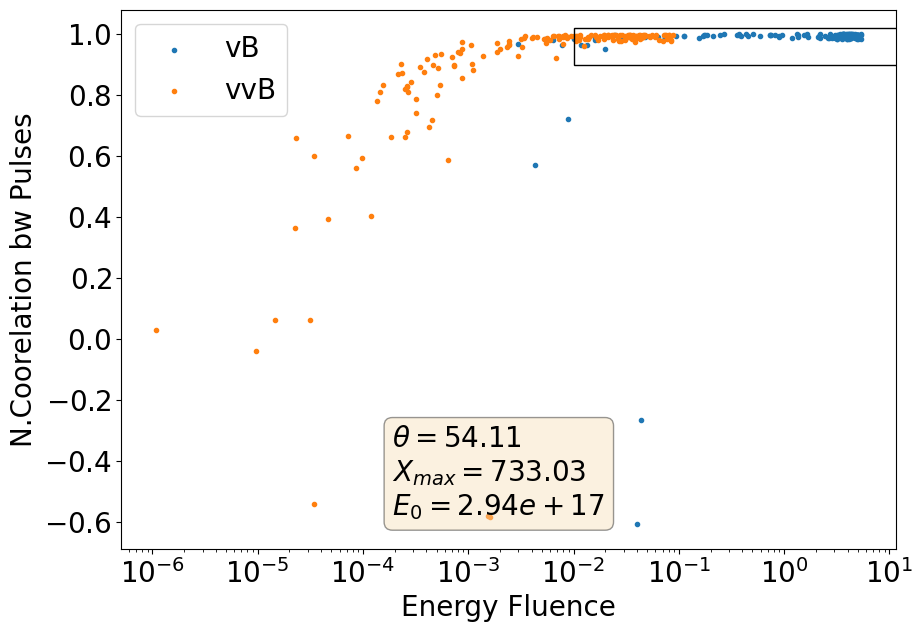

In [8]:
def plot_Eflu_vs_corr(real, pos, meta, sim, inp_meta):
    from view_scalars import get_fluences0, get_cross_correlation0, get_fluences1, get_cross_correlation1
    #plt.scatter(get_lateral_distance(real, pos, meta), get_cross_correlation1(real, pos, meta, pulses2=sim), marker='.')
    plt.figure(figsize=(10,7))
    plt.scatter(get_fluences0(real, pos, meta)[thin_or_not(real, pos, meta) > 0],
                get_cross_correlation0(real, pos, meta, pulses2=sim)[thin_or_not(real, pos, meta) > 0],
                label='vB',
                marker='.')
    plt.scatter(get_fluences1(real, pos, meta)[thin_or_not(real, pos, meta) > 0],
                get_cross_correlation1(real, pos, meta, pulses2=sim)[thin_or_not(real, pos, meta) > 0],
                label='vvB',
                marker='.')
    plt.text(0.35, 0.05, make_event_str(inp_meta), verticalalignment='bottom', bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.4), transform=plt.gca().transAxes)
    plt.xscale('log')
    plt.xlabel('Energy Fluence')
    plt.ylabel('N.Coorelation bw Pulses')
    plt.gca().add_patch(Rectangle((0.01, 0.9), 20,0.12 , fill=False))
    plt.legend();
    plt.show()
plot_Eflu_vs_corr(real, pos, meta, sim, data[1])

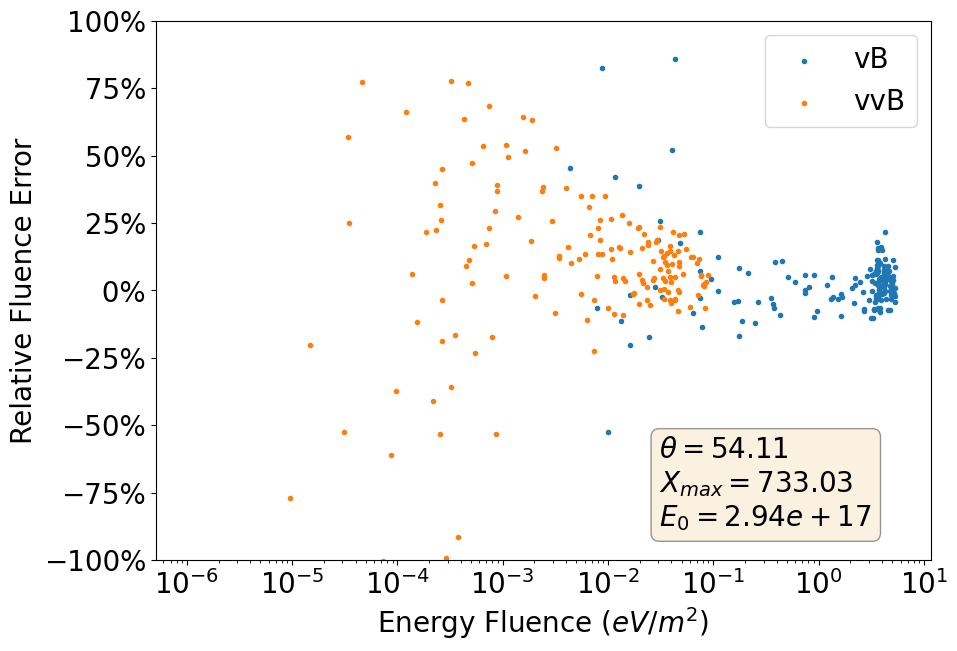

In [63]:
def plot_Eflu_vs_Efluerr(real, pos, meta, sim, inp_meta):
    from view_scalars import get_fluences0, get_fluences1
    #plt.scatter(get_lateral_distance(real, pos, meta), get_cross_correlation1(real, pos, meta, pulses2=sim), marker='.')
    plt.figure(figsize=(10,7))
    relative_fluence0 = (get_fluences0(real, pos, meta) - get_fluences0(sim, pos, meta)) / get_fluences0(real, pos, meta)
    relative_fluence1 = (get_fluences1(real, pos, meta) - get_fluences1(sim, pos, meta)) / get_fluences1(real, pos, meta)
    plt.scatter(get_fluences0(real, pos, meta)[thin_or_not(real, pos, meta) > 0],
                relative_fluence0[thin_or_not(real, pos, meta) > 0]*100,
                label='vB',
                marker='.')
    plt.scatter(get_fluences1(real, pos, meta)[thin_or_not(real, pos, meta) > 0],
                relative_fluence1[thin_or_not(real, pos, meta) > 0]*100,
                label='vvB',
                marker='.')
    plt.text(0.65, 0.05, make_event_str(inp_meta), verticalalignment='bottom', bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.4), transform=plt.gca().transAxes)
    plt.xscale('log')
    #plt.gca().add_patch(Rectangle((0.01, -0.5), 350,1 , fill=False))
    plt.ylim([-100, 100])
    plt.gca().yaxis.set_major_formatter('{x:3.0f}%')
    #plt.xlim([0.01, 350])
    plt.xlabel('Energy Fluence $(eV/m^2)$')
    plt.ylabel('Relative Fluence Error')
    plt.legend();
plot_Eflu_vs_Efluerr(real, pos, meta, sim, data[1])
plt.savefig('rel_fluence_error.pdf', format='pdf')

In [10]:
SIM_NUMBER = int(data[1][0])
HDF5_PATH = f"/run/media/pranav/404315c2-8ae6-4cf8-9d67-d887bd663ee8/radio_data/hdf5_files/{SIM_NUMBER//100:04d}/SIM{SIM_NUMBER:06d}.hdf5"

In [11]:
# from radio_plotter import print_hdf5_file
# print_hdf5_file(HDF5_PATH)

In [12]:
import h5py
f_h5 = h5py.File(HDF5_PATH, "r")
pos_h5 = f_h5["/highlevel/obsplane_na_na_vB_vvB"]["antenna_position_vBvvB"]
real_h5 = f_h5["/highlevel/obsplane_na_na_vB_vvB"]["traces_filtered"]

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/run/media/pranav/404315c2-8ae6-4cf8-9d67-d887bd663ee8/radio_data/hdf5_files/0198/SIM019810.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
footprint(real_h5, pos_h5, meta, sim, data[1], index=0, radius=800)
footprint(real_h5, pos_h5, meta, sim, data[1], index=1, radius=800)

In [ ]:
from radioNN.process_network import fit_plane_and_return_3d_grid

In [ ]:
pos_h5.shape

In [ ]:
325 - 240

In [ ]:
pos_h5_sph = cart2sph(pos_h5[:])
N = pos_h5_sph.shape[0]
intermediate_test = process.model(torch.Tensor(np.repeat([data[0]], N, axis=0)), torch.Tensor(np.repeat([data[1]], N, axis=0)), torch.Tensor(pos_h5_sph))[1].detach().numpy()

In [ ]:
def compare_pulses(pulsesA, pulsesB, posAB):
    for random_pulse_id in np.random.randint(low=0, high=85, size=85):
        if np.max(pulsesA[random_pulse_id,:,0]) < 1e-5:
            continue
        fig, ax = plt.subplot_mosaic('AB', figsize = (17, 5))
        ax['A'].plot(pulsesA[random_pulse_id,:,0]/1e-6, label='CoREAS')
        ax['A'].plot(pulsesB[random_pulse_id,:,0]/1e-6, label='NN')
        ax['A'].legend()
        ax['A'].yaxis.set_major_formatter('{x:0.1f}')
        ax['A'].set_ylabel(r'$\mu V$')
        ax['B'].plot(pulsesA[random_pulse_id,:,1]/1e-6, label='CoREAS')
        ax['B'].plot(pulsesB[random_pulse_id,:,1]/1e-6, label='NN')
        ax['B'].yaxis.set_major_formatter('{x:0.1f}')
        ax['B'].set_ylabel(r'$\mu V$')
        ax['B'].legend()
        fig.suptitle(f"Pos {posAB[random_pulse_id]}")
        plt.show()
        
compare_pulses(real_h5, intermediate_test, pos_h5)

In [ ]:
plot_Eflu_vs_corr(real_h5[:-240], pos_h5[:-240], meta, intermediate_test[:-240], data[1])

In [13]:
N = 100*100
pos_grid = fit_plane_and_return_3d_grid(pos)
pos_grid_sph = cart2sph(pos_grid)
ans = process.model(torch.Tensor(np.repeat([data[0]], N, axis=0)), torch.Tensor(np.repeat([data[1]], N, axis=0)), torch.Tensor(pos_grid_sph))

NameError: name 'fit_plane_and_return_3d_grid' is not defined

In [ ]:
ans[1].shape

In [22]:
conversion_factor_integrated_signal = 2.65441729e-3 * 6.24150934e18 *1e-9 # to convert V**2/m**2 * s -> J/m**2 -> eV/m**2
fake_fluence0 = lambda x: np.sum(x.detach().numpy()[:,:,0]**2, axis=1)*conversion_factor_integrated_signal
fake_fluence1 = lambda x: np.sum(x.detach().numpy()[:,:,1]**2, axis=1)*conversion_factor_integrated_signal

In [23]:
fake_fluence0(ans[1]).shape

NameError: name 'ans' is not defined

In [ ]:
from view_scalars import get_fluences0, get_fluences1, get_max_value0, get_max_value1
manual_footprint(pos, fake_fluence0(ans[1]))
manual_footprint(pos, fake_fluence1(ans[1]))

(13,)

In [47]:
print(make_event_str(data[1]))

$\theta=54.11$
$X_{max}=733.03$
$E_0=2.94e+17$


vmin =  -5.3156143467881994e-06
vmax =  5.3672537266549645
vmin =  -1.4810727821213849e-05
vmax =  0.08855822211502747
vmin =  0.0007618384342884268
vmax =  5.60735094479146
vmin =  1.0498490549932364e-05
vmax =  0.089708076654353


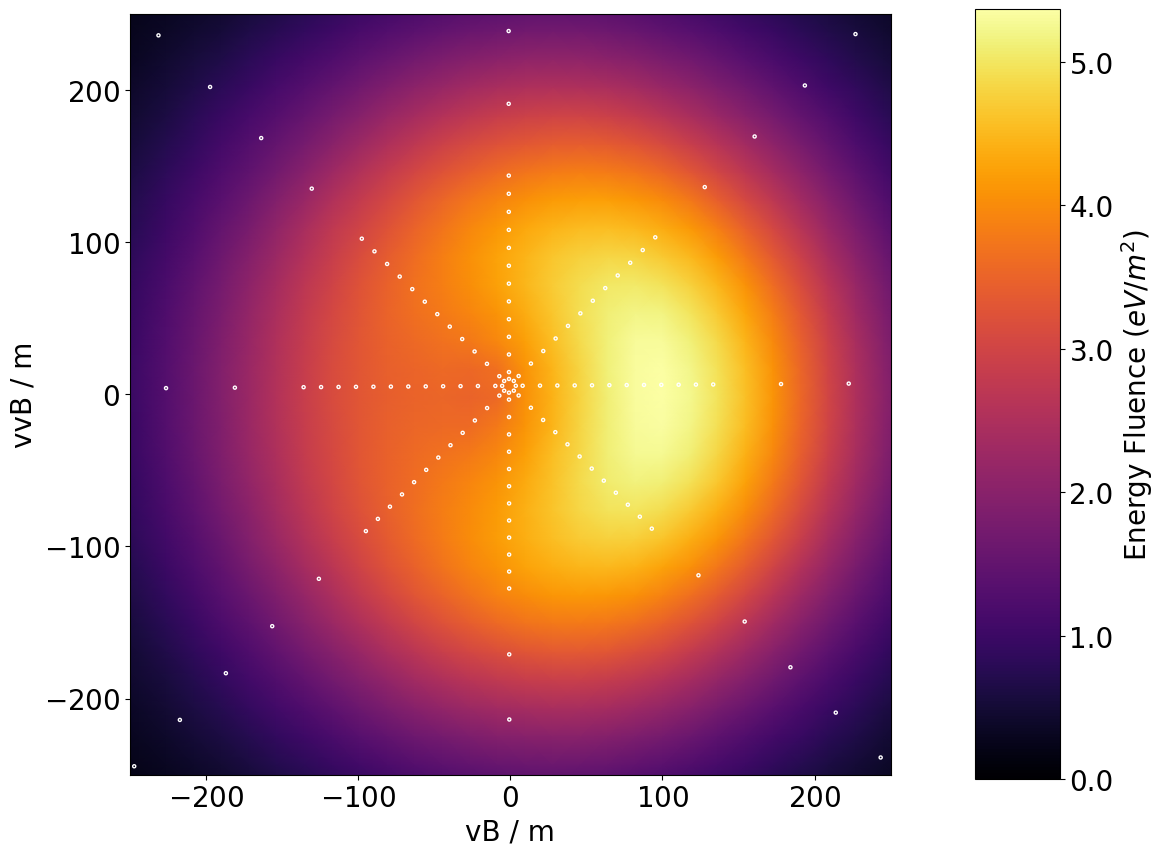

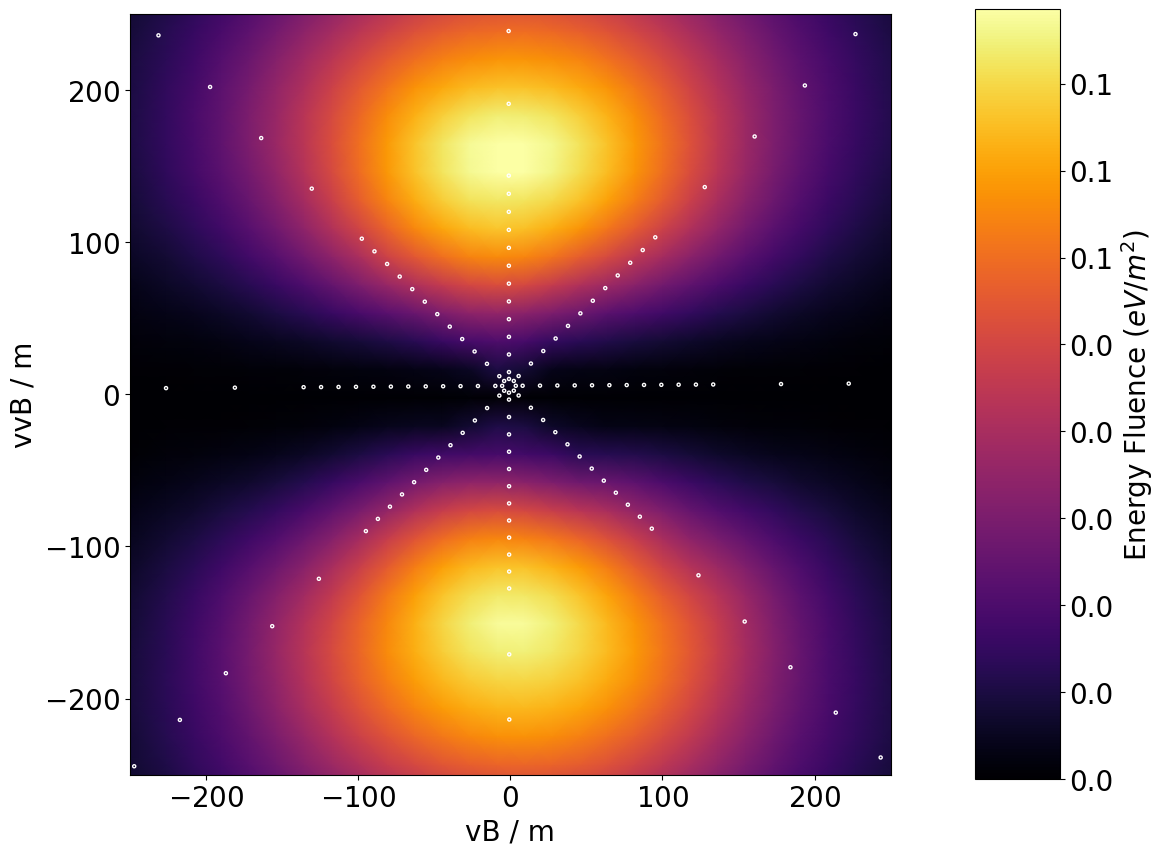

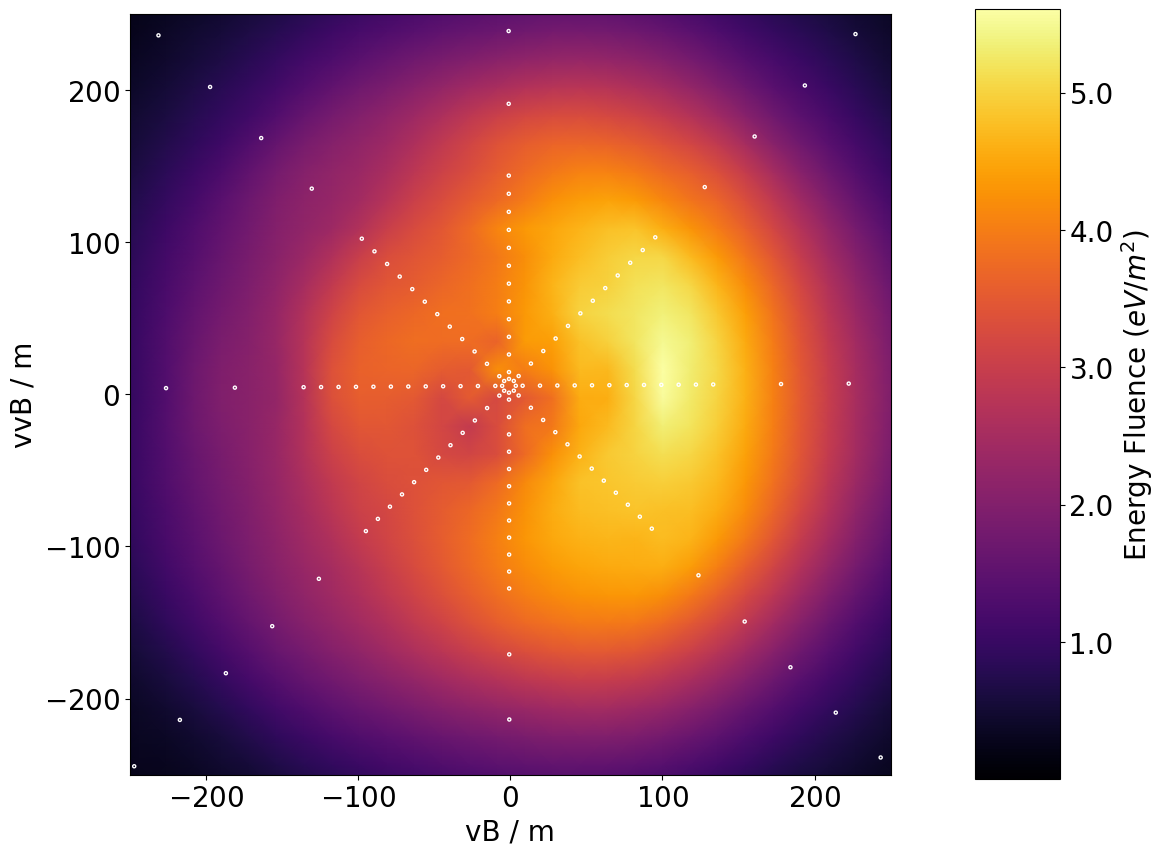

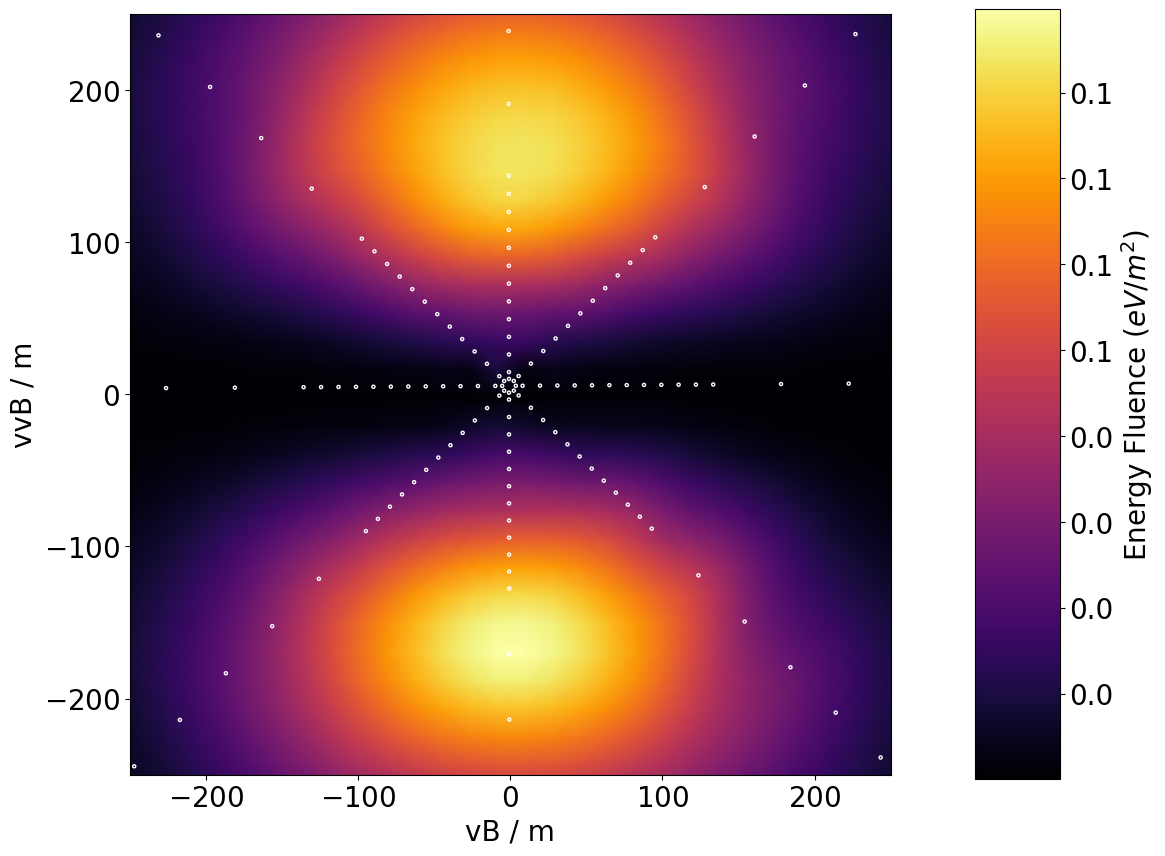

In [49]:
footprint(real, pos, meta, sim, data[1], radius=250)
plt.savefig("fluence_coreas_0.pdf", format='pdf')
footprint(real, pos, meta, sim, data[1], index=1, radius=250)
plt.savefig("fluence_coreas_1.pdf", format='pdf')
footprint(sim, pos, meta, sim, data[1], radius=250)
plt.savefig("fluence_nn_0.pdf", format='pdf')
footprint(sim, pos, meta, sim, data[1], index=1, radius=250)
plt.savefig("fluence_nn_1.pdf", format='pdf')

In [25]:
np.repeat([data[0]], 10, axis=0).shape

(10, 7, 300)

In [26]:
make_table(data[1])

{'Sim number': 19810.0,
 'Zenith': 54.111595,
 'X_max': 733.0342173576355,
 'density at X_max': 1e-09,
 'height at X_max': 747012.2575759888,
 'E_em': 2.3648215898285603e+17,
 'sin(geomagnetic_angle)': 0.9540191,
 'B inclination': -0.6296187,
 'B declination': 0.0,
 'B strength': 24.137766,
 'primary particle': 5626.0,
 'primary energy': 2.9397945e+17,
 'Azimuth': 4.538392}

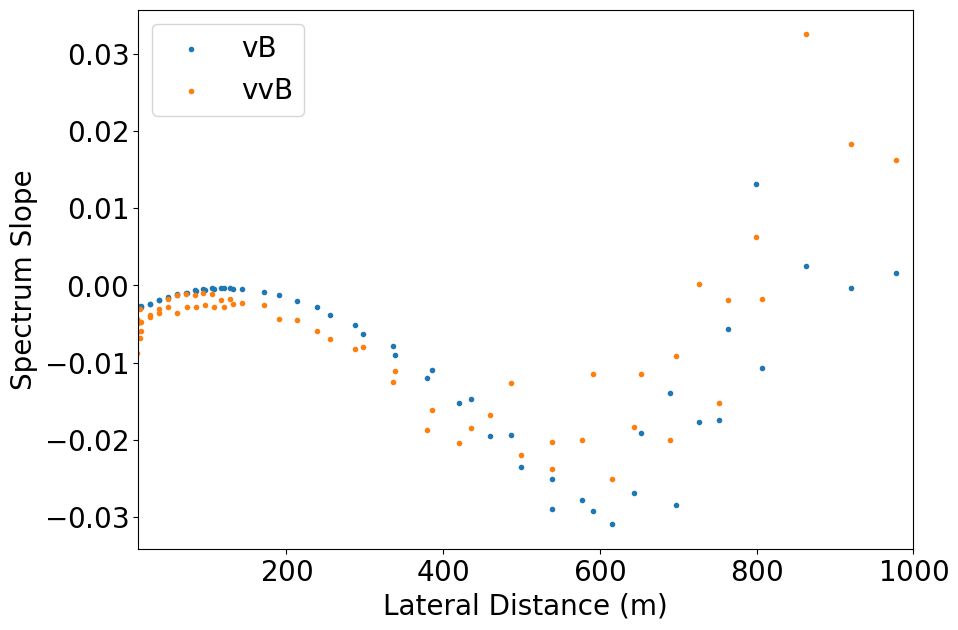

In [27]:
def thinning_plot(real, pos, meta, sim, inp_meta):
    from view_scalars import get_lateral_distance, get_cross_correlation0, get_cross_correlation1, get_thinning_factor
    plt.figure(figsize=(10,7))  
    mask = np.abs(pos[:, 0]) < 10
    plt.scatter(get_lateral_distance(real[mask], pos[mask], meta[mask]), get_thinning_factor(real[mask], pos[mask], meta[mask]), marker='.', label='vB')
    plt.scatter(get_lateral_distance(real[mask], pos[mask], meta[mask]), get_thinning_factor(real[mask], pos[mask], meta[mask], index=1), marker='.', label='vvB')
    plt.xlabel('Lateral Distance (m)')
    plt.ylabel('Spectrum Slope')
    plt.xlim([11, 1000])
    plt.legend()
    plt.show()
thinning_plot(real, pos, meta, sim, data[1])

In [28]:
#footprint(real, pos, meta, sim, data[1], index=2)

In [29]:
#footprint(real, pos, meta, sim, data[1], index=2)

In [30]:
def radiation_energy(real, pos, meta, sim, inp_meta):
    mask = np.abs(pos[:,0]<10)
    

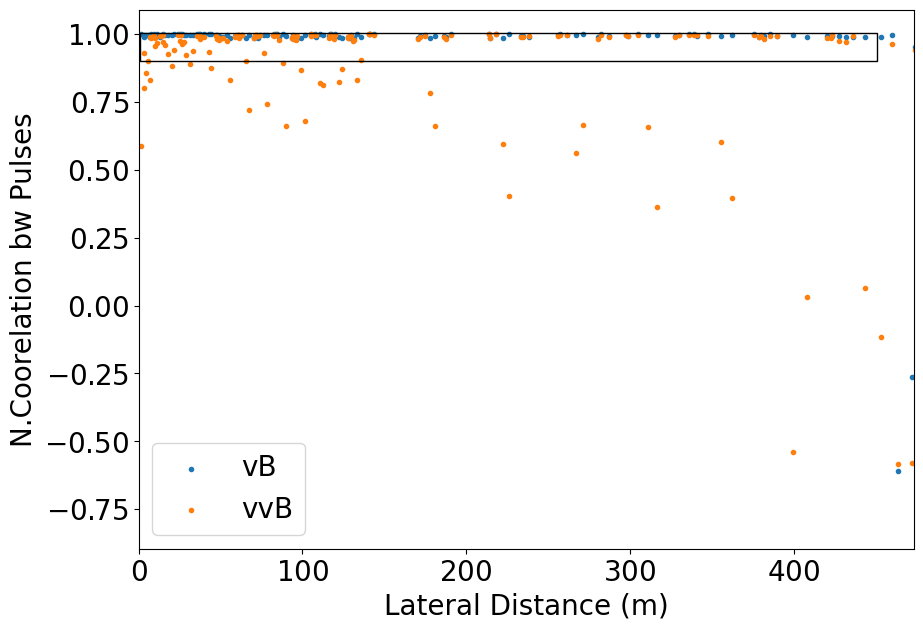

In [31]:
def plot_d_vs_corr(real, pos, meta, sim, inp_meta):
    from view_scalars import get_lateral_distance, get_cross_correlation0, get_cross_correlation1
    plt.figure(figsize=(10,7))
    
    plt.scatter(get_lateral_distance(real, pos, meta), get_cross_correlation0(real, pos, meta, pulses2=sim), marker='.', label='vB')
    plt.scatter(get_lateral_distance(real, pos, meta), get_cross_correlation1(real, pos, meta, pulses2=sim), marker='.', label='vvB')

    plt.xlim([0,0.85*np.max(get_lateral_distance(real, pos, meta)[thin_or_not(real, pos, meta) > 0])])
    #plt.ylim([0.9, 1.005])
    #plt.text(0.70, 0.05, make_event_str(inp_meta), verticalalignment='bottom',transform=plt.gca().transAxes, bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.4))
    plt.gca().add_patch(Rectangle((1.1, 0.9), 450,0.105 , fill=False))
    plt.legend()
    plt.xlabel('Lateral Distance (m)')
    plt.ylabel('N.Coorelation bw Pulses')
    plt.show()
plot_d_vs_corr(real, pos, meta, sim, data[1])

vmin =  -5.3156143467881994e-06
vmax =  5.3672537266549645
vmin =  0.0007618384342884268
vmax =  5.60735094479146
vmin =  -1.4810727821213849e-05
vmax =  0.08855822211502747
vmin =  1.0498490549932364e-05
vmax =  0.089708076654353


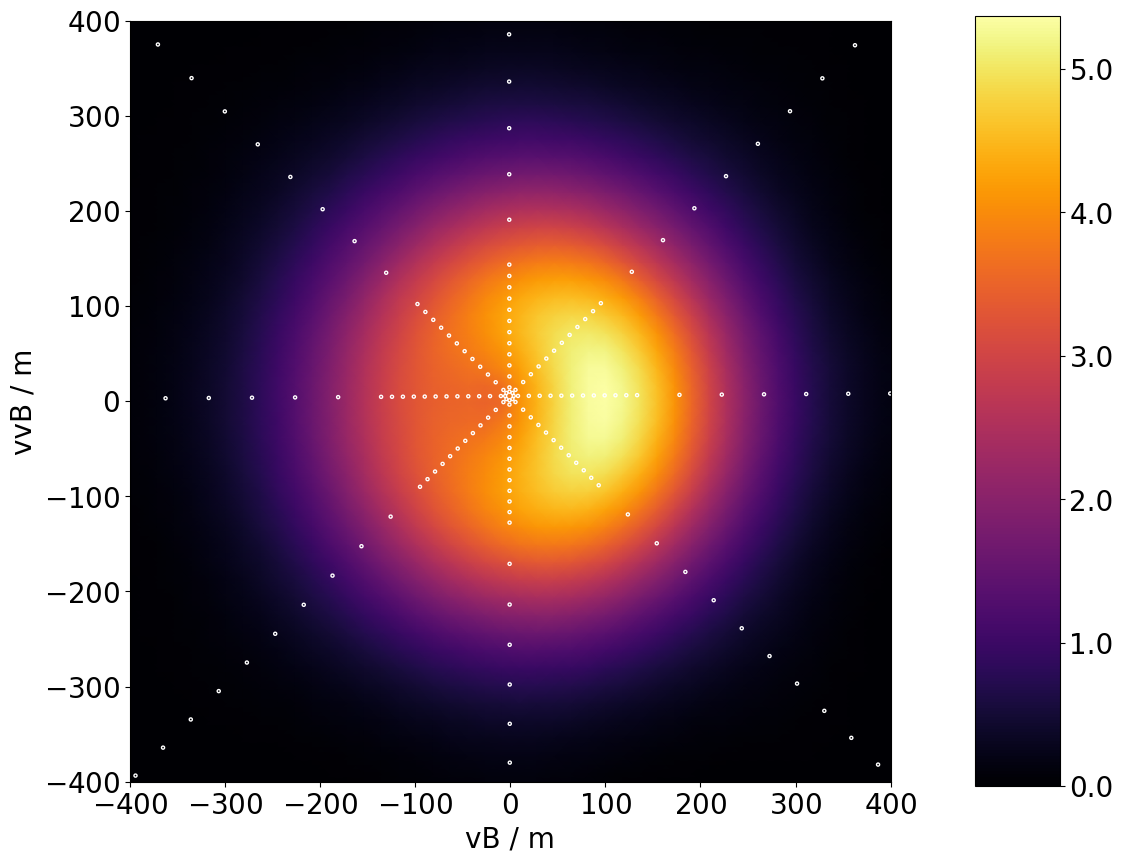

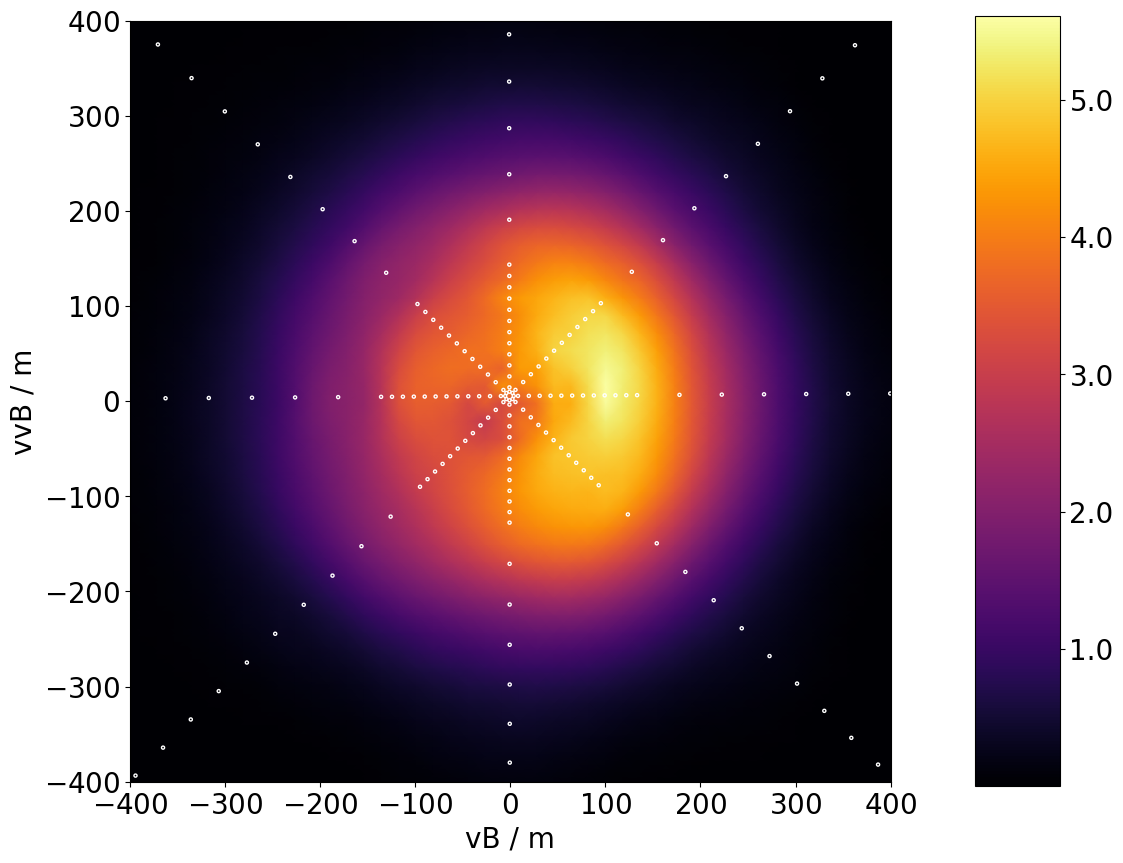

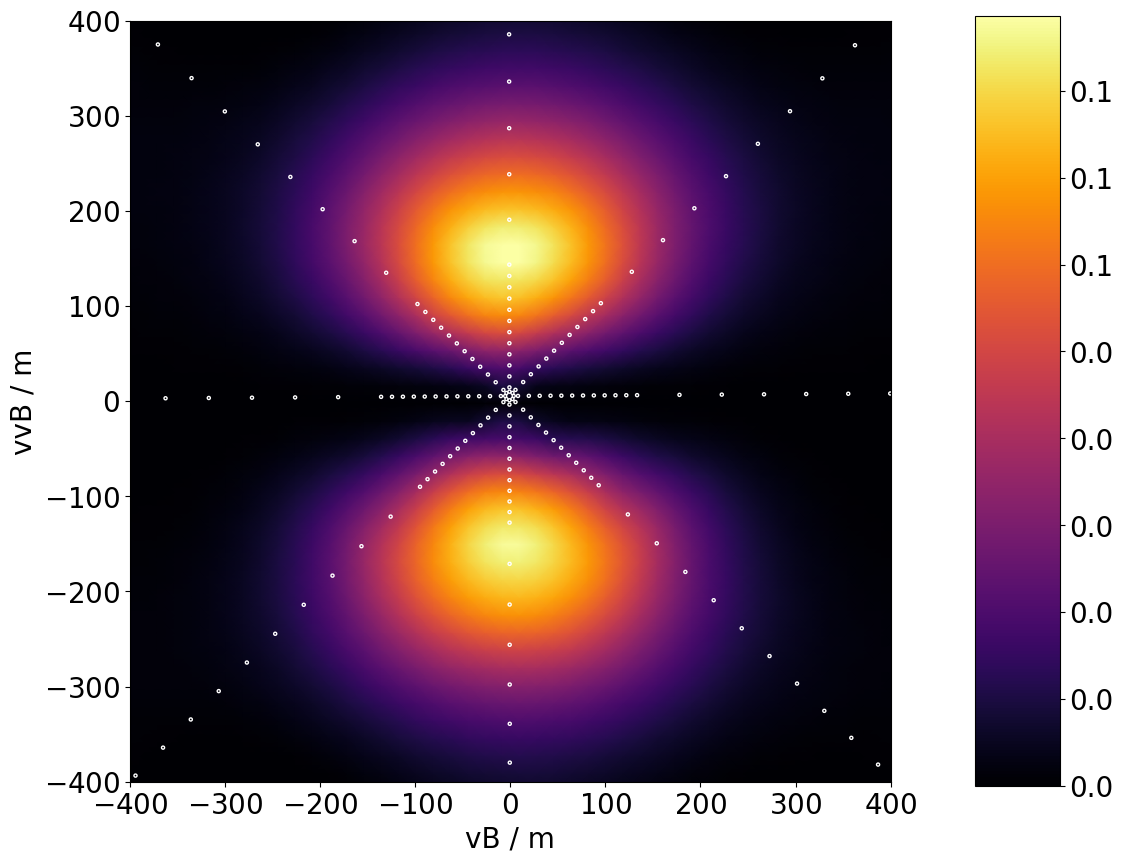

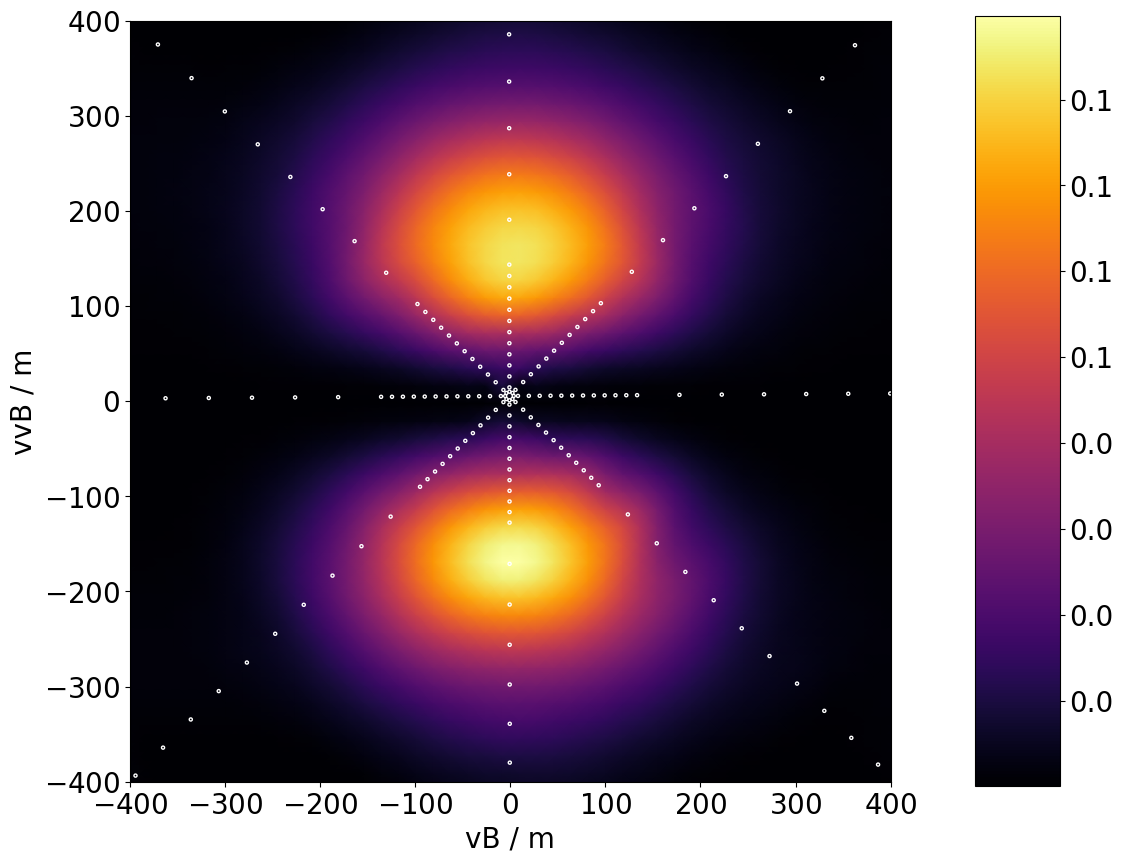

In [32]:


footprint(real, pos, meta, sim, data[1], radius = 400)
footprint(sim, pos, meta, sim, data[1], radius = 400)
footprint(real, pos, meta, sim, data[1], index=1, radius = 400)
footprint(sim, pos, meta, sim, data[1], index=1, radius = 400)

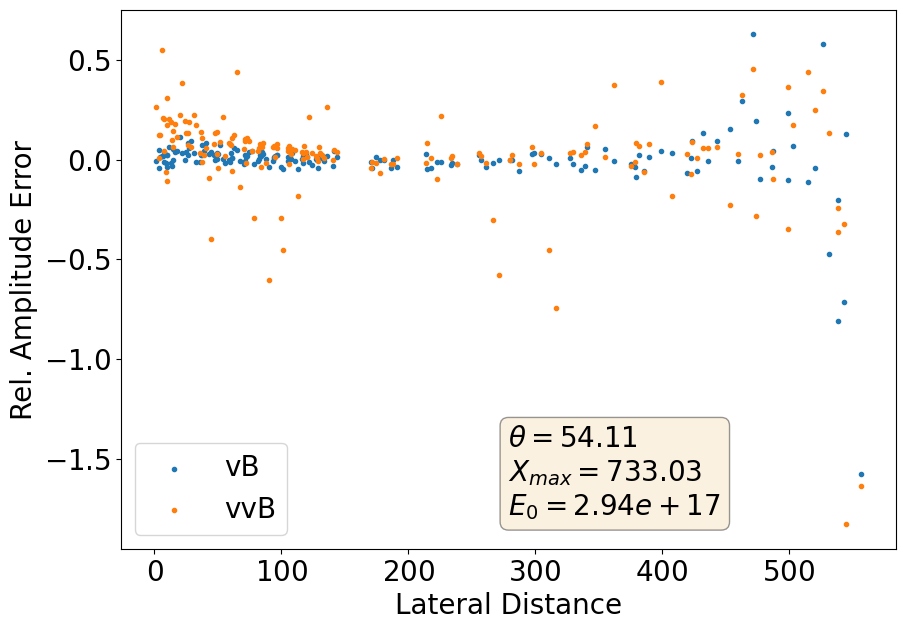

In [33]:
def plot_d_vs_maxerr(real, pos, meta, sim, inp_meta):
    from view_scalars import get_lateral_distance, get_max_value0, get_max_value1
    #plt.scatter(get_lateral_distance(real, pos, meta), get_cross_correlation1(real, pos, meta, pulses2=sim), marker='.')
    plt.figure(figsize=(10,7))
    relative_amplitude0 = (get_max_value0(real, pos, meta) - get_max_value0(sim, pos, meta)) / get_max_value0(real, pos, meta)
    relative_amplitude1 = (get_max_value1(real, pos, meta) - get_max_value1(sim, pos, meta)) / get_max_value1(real, pos, meta)
    plt.scatter(get_lateral_distance(real, pos, meta)[thin_or_not(real, pos, meta) > 0],
                relative_amplitude0[thin_or_not(real, pos, meta) > 0],
                label='vB',
                marker='.')
    plt.scatter(get_lateral_distance(real, pos, meta)[thin_or_not(real, pos, meta) > 0],
                relative_amplitude1[thin_or_not(real, pos, meta) > 0],
                label='vvB',
                marker='.')
    plt.text(0.50, 0.05, make_event_str(data[1]), verticalalignment='bottom', bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.4), transform=plt.gca().transAxes)
    plt.xlabel('Lateral Distance')
    plt.ylabel('Rel. Amplitude Error')
    plt.legend();
    plt.show()
plot_d_vs_maxerr(real, pos, meta, sim, data[1])

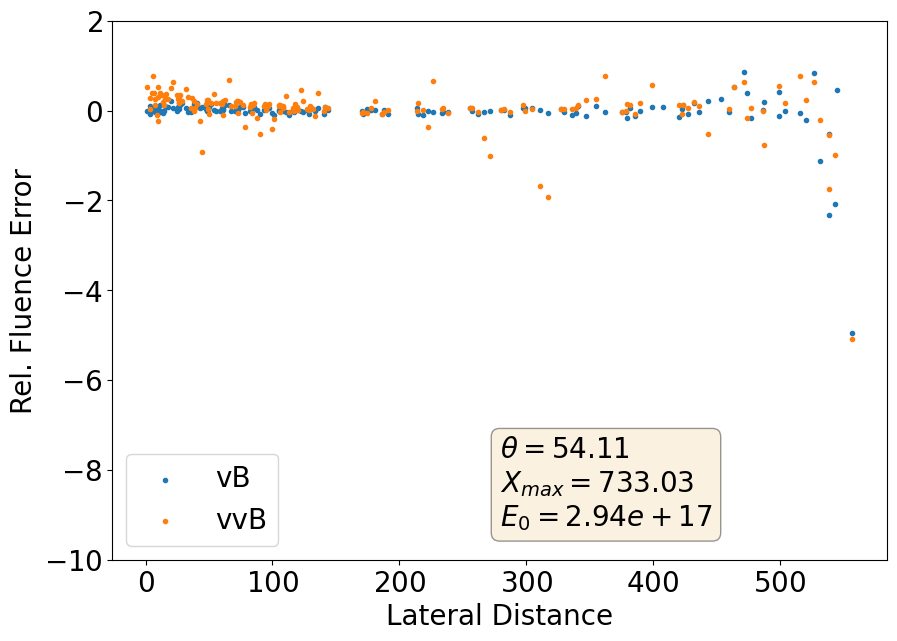

In [34]:
def plot_d_vs_Efluerr(real, pos, meta, sim, inp_meta):
    from view_scalars import get_lateral_distance, get_fluences0, get_fluences1
    #plt.scatter(get_lateral_distance(real, pos, meta), get_cross_correlation1(real, pos, meta, pulses2=sim), marker='.')
    plt.figure(figsize=(10,7))
    relative_amplitude0 = (get_fluences0(real, pos, meta) - get_fluences0(sim, pos, meta)) / get_fluences0(real, pos, meta)
    relative_amplitude1 = (get_fluences1(real, pos, meta) - get_fluences1(sim, pos, meta)) / get_fluences1(real, pos, meta)
    plt.scatter(get_lateral_distance(real, pos, meta)[thin_or_not(real, pos, meta) > 0],
                relative_amplitude0[ thin_or_not(real, pos, meta)> 0],
                label='vB',
                marker='.')
    plt.scatter(get_lateral_distance(real, pos, meta)[thin_or_not(real, pos, meta) > 0],
                relative_amplitude1[thin_or_not(real, pos, meta) > 0],
                label='vvB',
                marker='.')
    plt.text(0.50, 0.05, make_event_str(data[1]), verticalalignment='bottom', bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.4), transform=plt.gca().transAxes)
    plt.ylim([-10, 2])
    plt.xlabel('Lateral Distance')
    plt.ylabel('Rel. Fluence Error')
    plt.legend();
    plt.show()
plot_d_vs_Efluerr(real, pos, meta, sim, data[1])

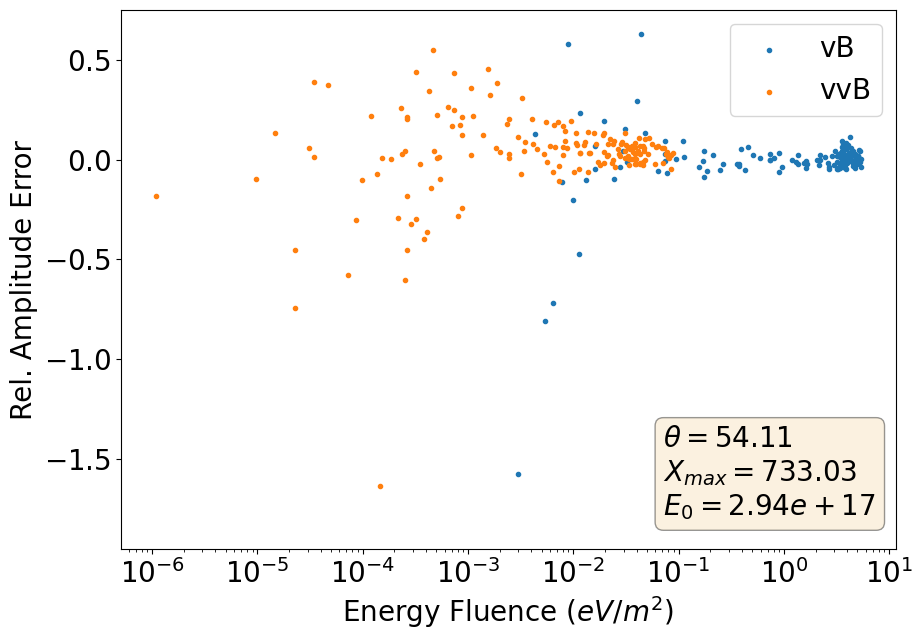

In [52]:
def plot_Eflu_vs_maxerr(real, pos, meta, sim, inp_meta):
    from view_scalars import get_fluences0, get_max_value0, get_max_value1, get_fluences1
    #plt.scatter(get_lateral_distance(real, pos, meta), get_cross_correlation1(real, pos, meta, pulses2=sim), marker='.')
    plt.figure(figsize=(10,7))
    relative_amplitude0 = (get_max_value0(real, pos, meta) - get_max_value0(sim, pos, meta)) / get_max_value0(real, pos, meta)
    relative_amplitude1 = (get_max_value1(real, pos, meta) - get_max_value1(sim, pos, meta)) / get_max_value1(real, pos, meta)
    plt.scatter(get_fluences0(real, pos, meta)[thin_or_not(real, pos, meta) > 0],
                relative_amplitude0[thin_or_not(real, pos, meta) > 0],
                label='vB',
                marker='.')
    plt.scatter(get_fluences1(real, pos, meta)[thin_or_not(real, pos, meta) > 0],
                relative_amplitude1[thin_or_not(real, pos, meta) > 0],
                label='vvB',
                marker='.')
    plt.text(0.70, 0.05, make_event_str(data[1]), verticalalignment='bottom', bbox = dict(boxstyle='round', facecolor='wheat', alpha=0.4), transform=plt.gca().transAxes)
    #plt.gca().add_patch(Rectangle((0.01, -0.25), 350,0.5 , fill=False))
    #plt.xlim([0.01, 350])
    #plt.ylim([-0.25, 0.25])
    plt.xscale('log')
    plt.xlabel(r'Energy Fluence $(eV/m^2)$')
    plt.ylabel('Rel. Amplitude Error')
    plt.legend();
    plt.show()
plot_Eflu_vs_maxerr(real, pos, meta, sim, data[1])

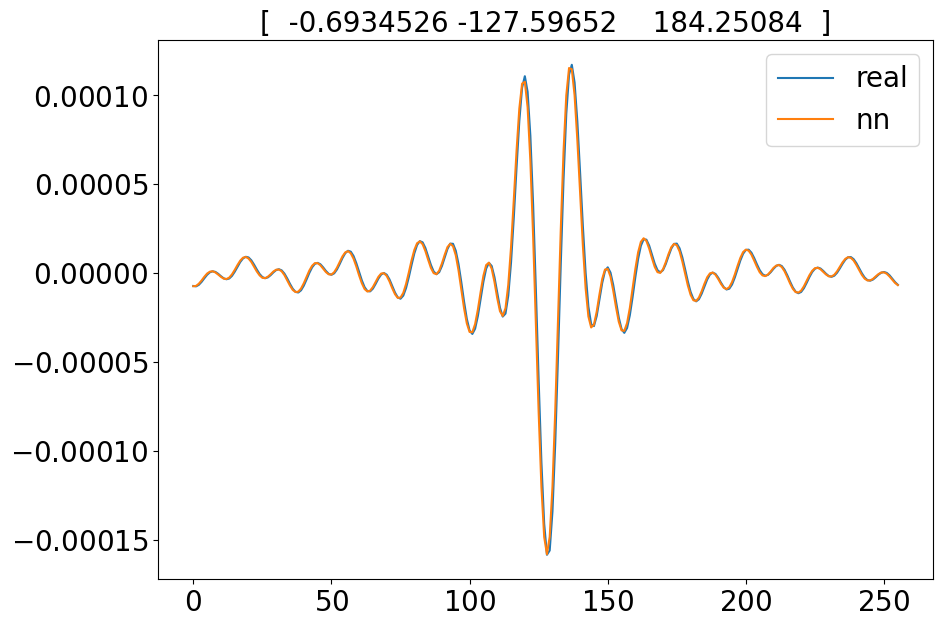

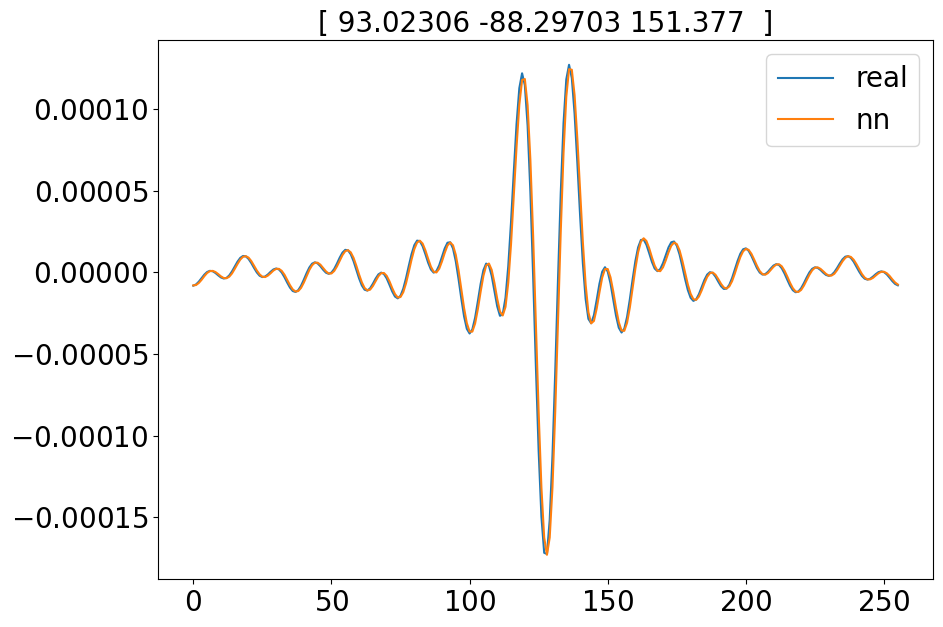

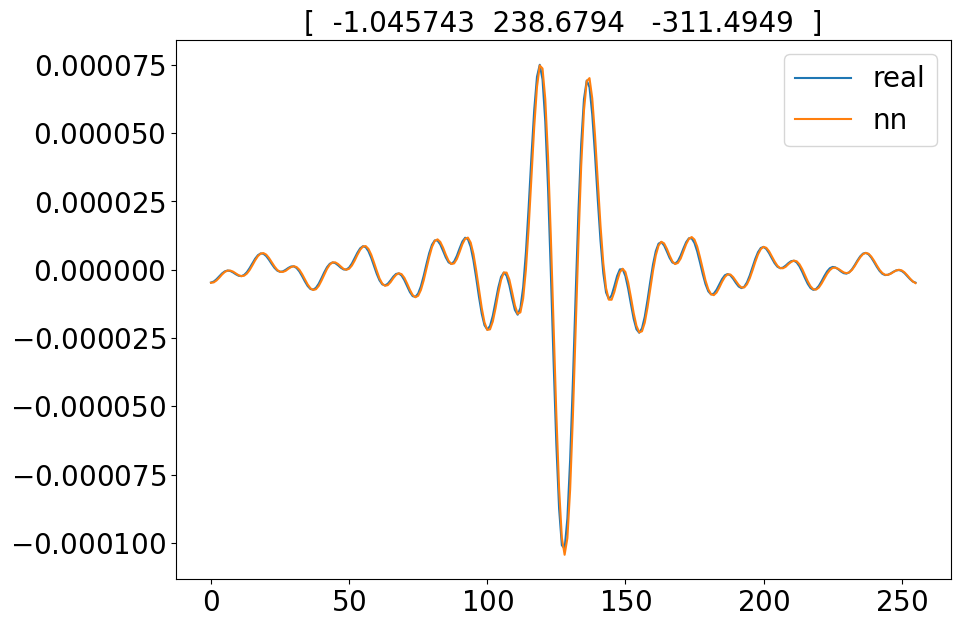

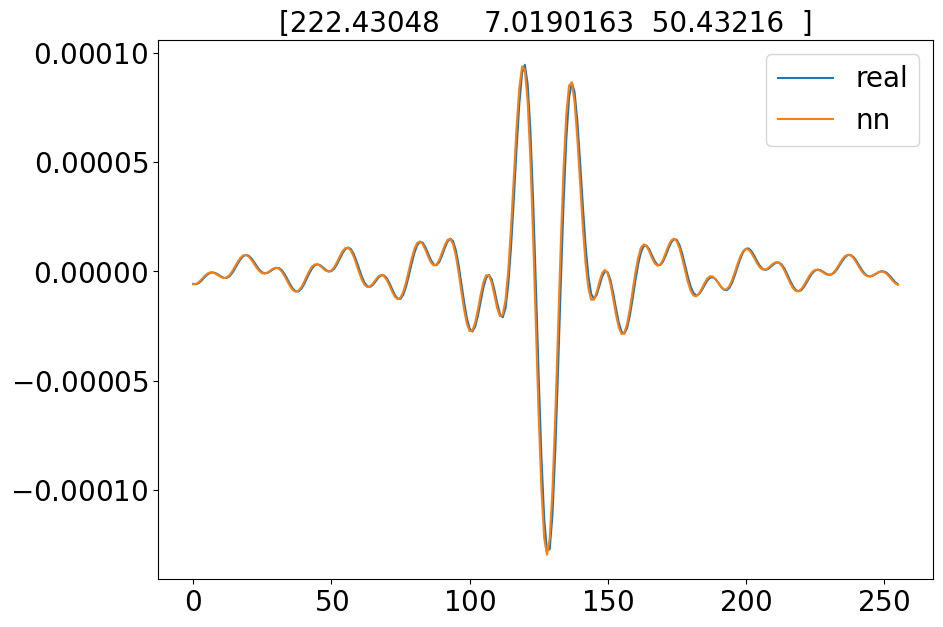

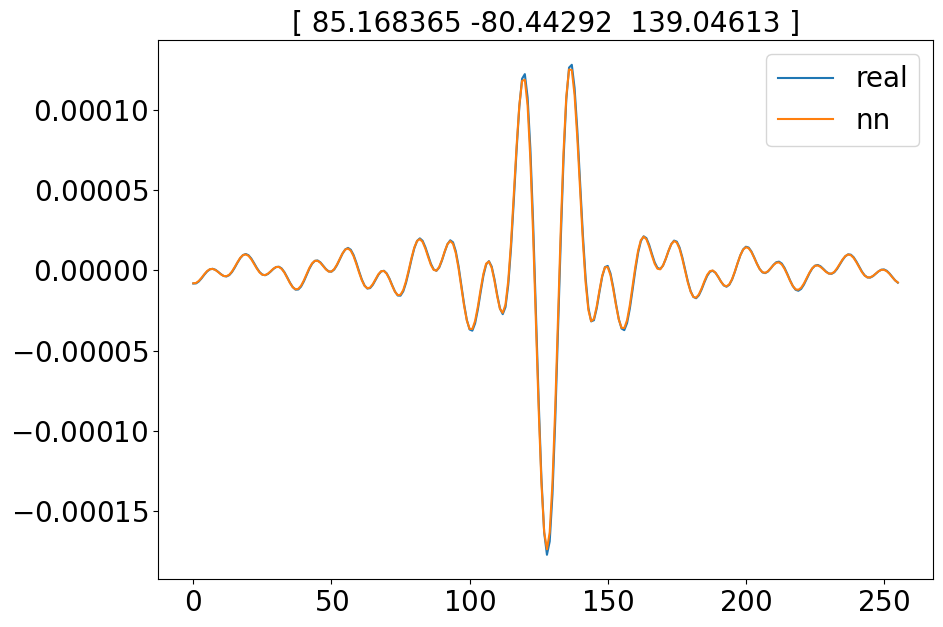

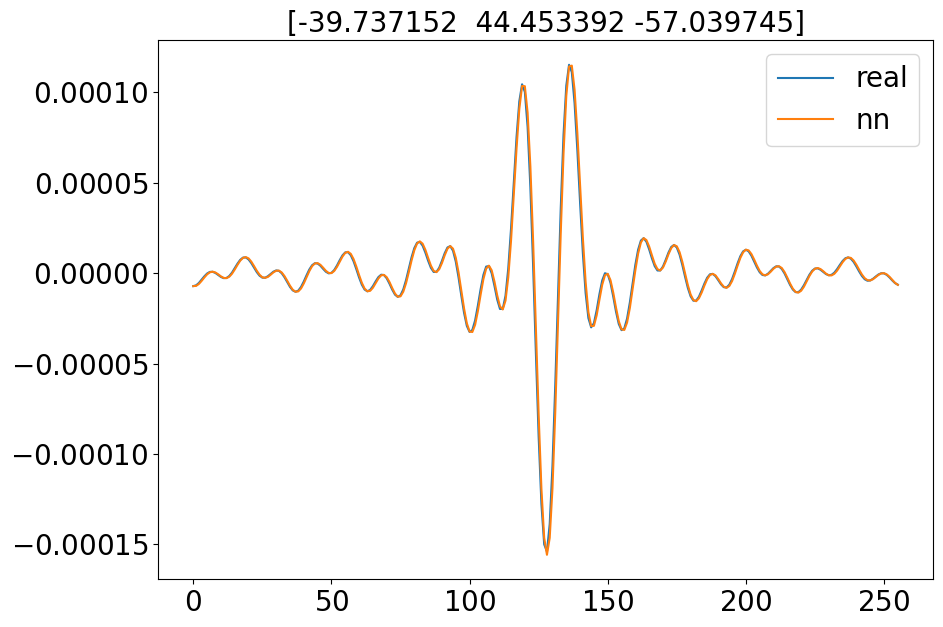

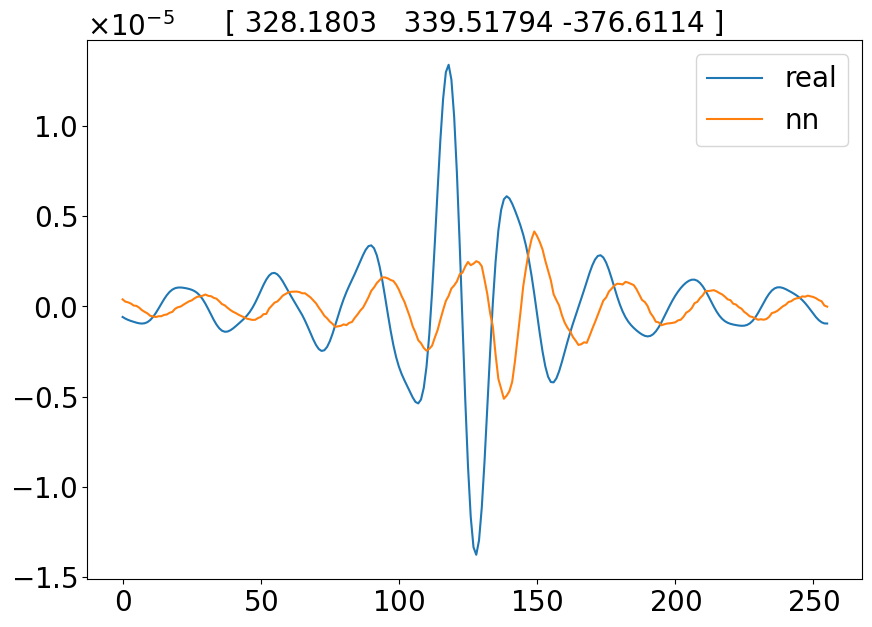

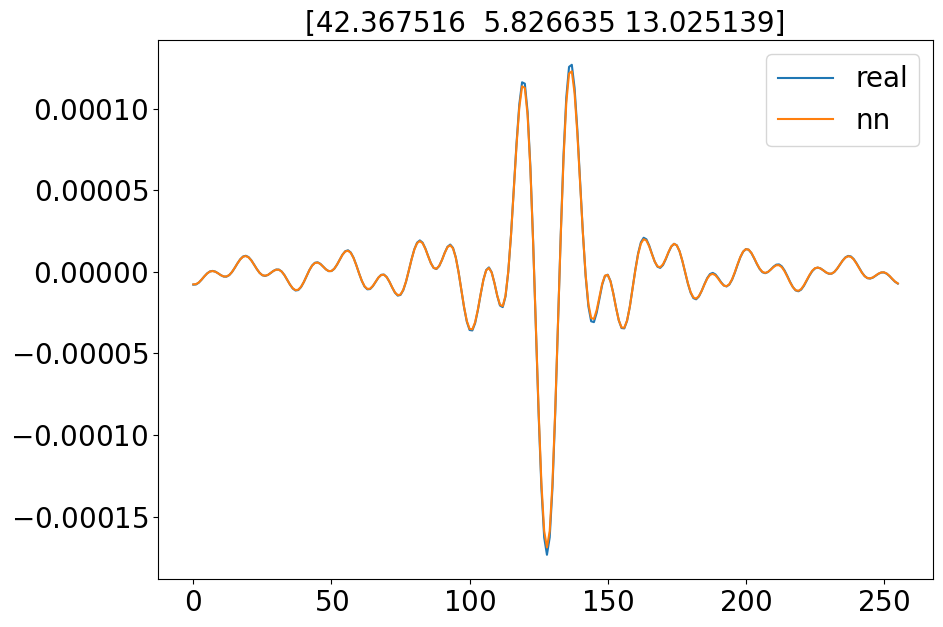

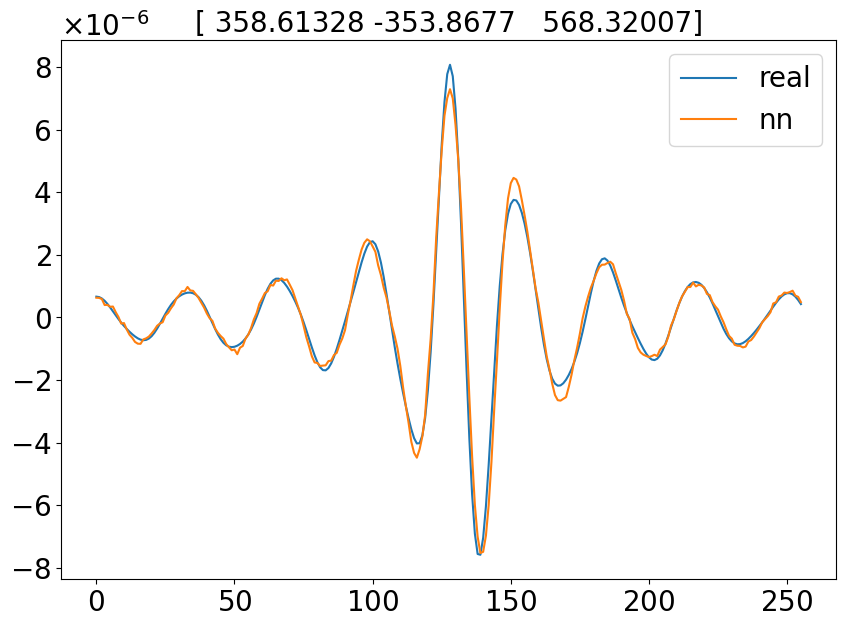

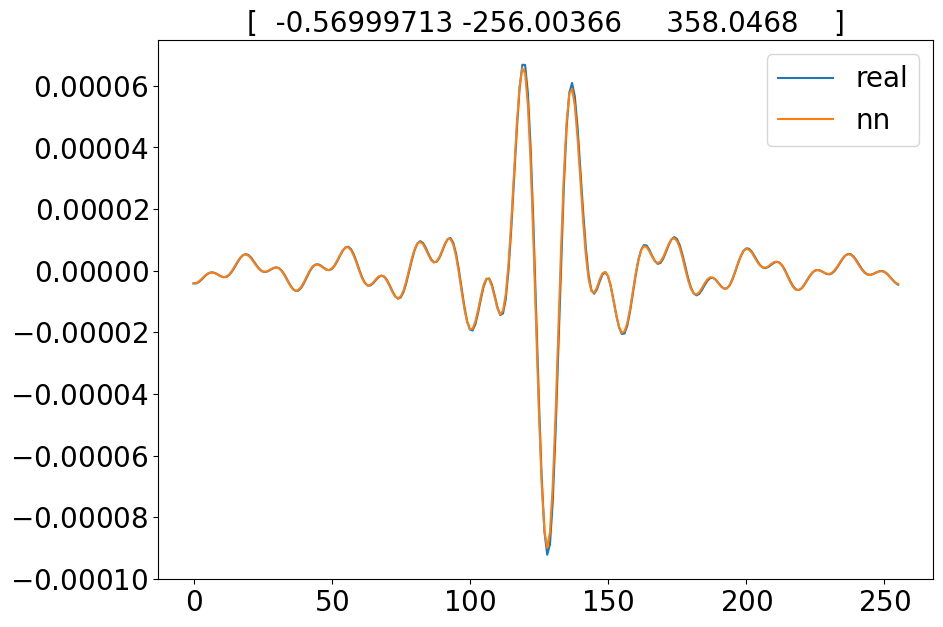

In [36]:
for _ in range(10):
    index = np.random.choice(np.argwhere(thin_or_not(real, pos, meta) > 0).flatten())
    plt.figure(figsize=(10, 7))
    plt.rcParams['axes.formatter.use_mathtext'] = True
    plt.plot(real[index, :, 0], label='real')
    plt.plot(sim[index,:,0], label='nn')
    plt.legend()
    plt.title(pos[index])
    plt.show()

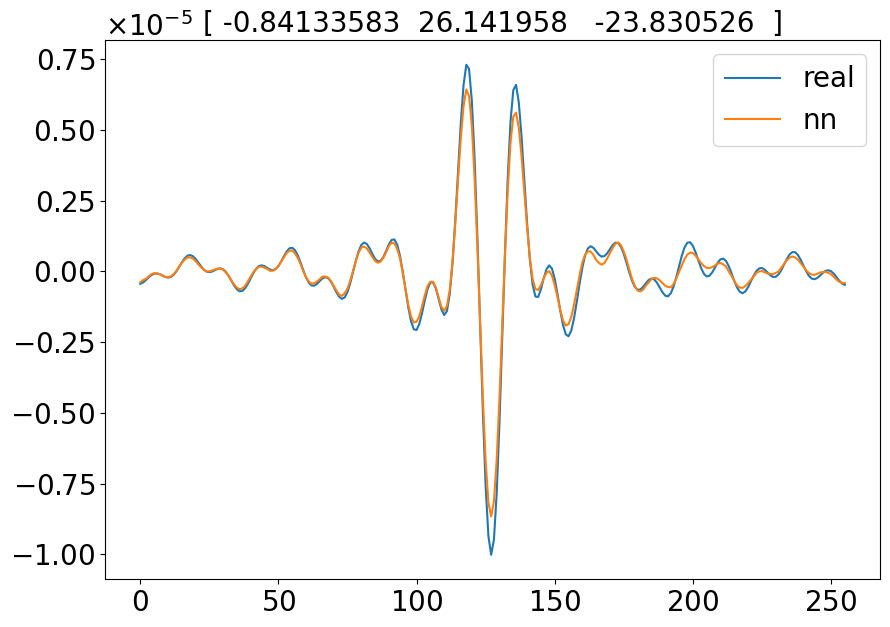

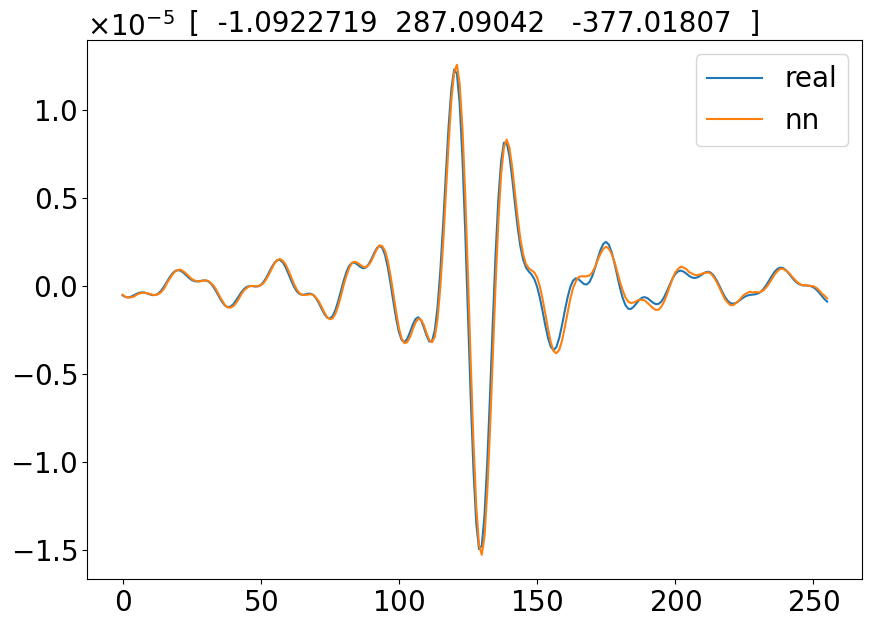

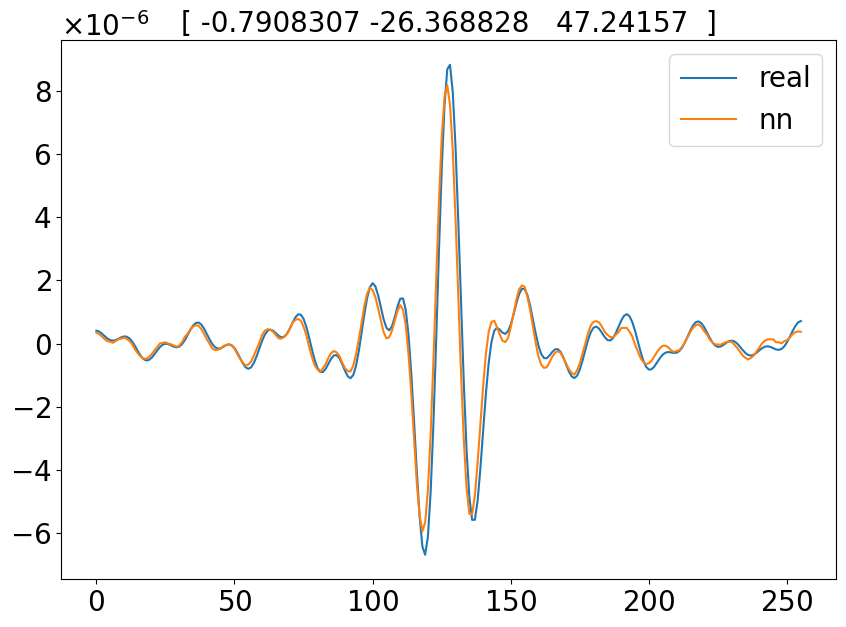

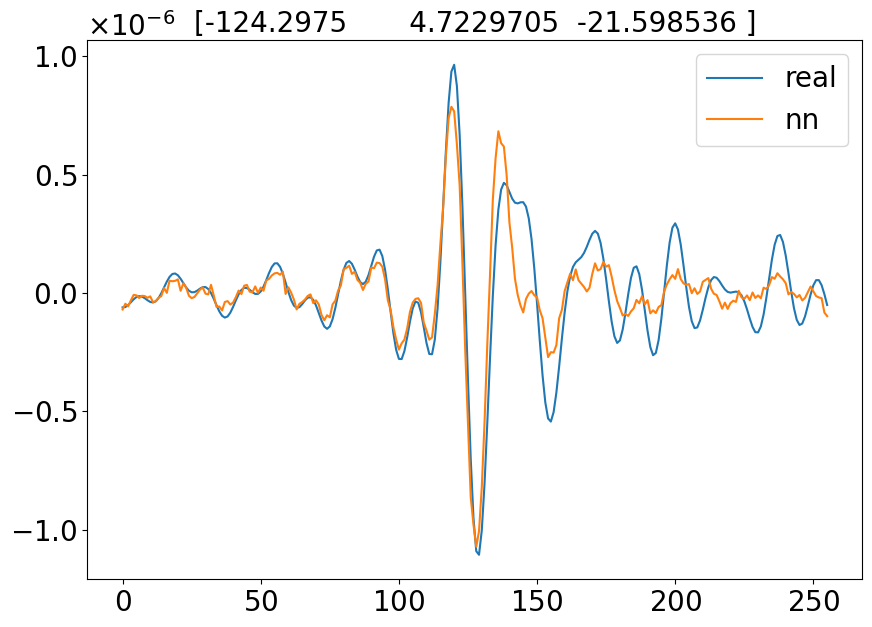

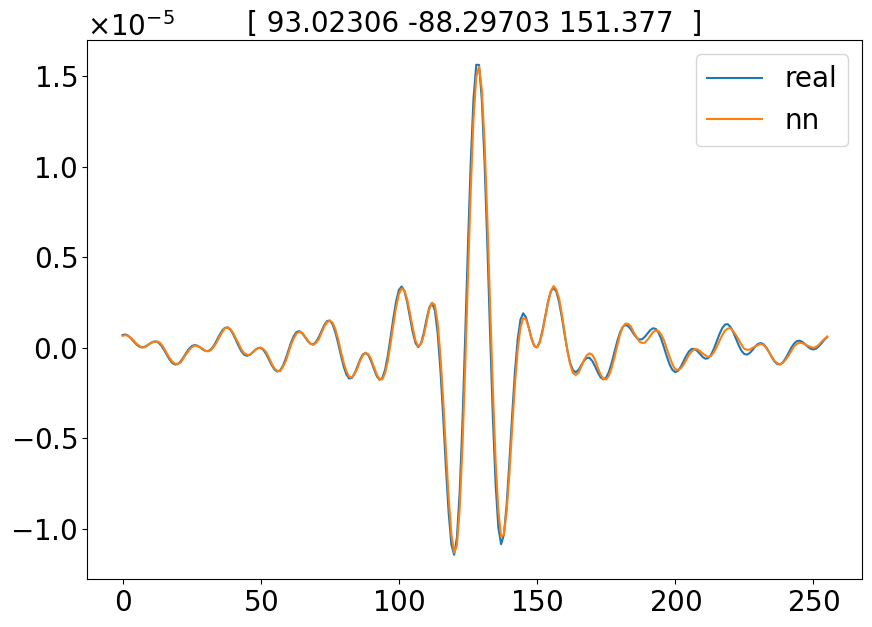

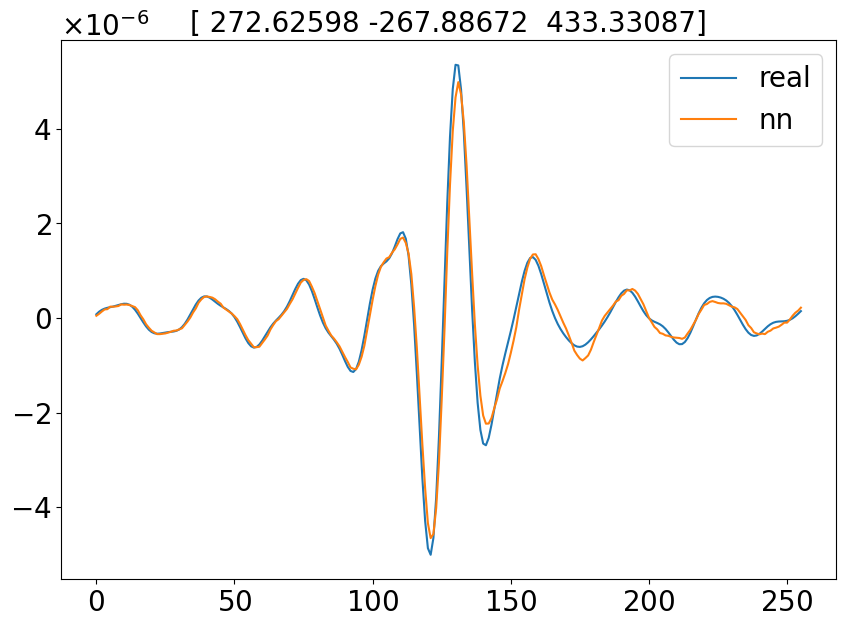

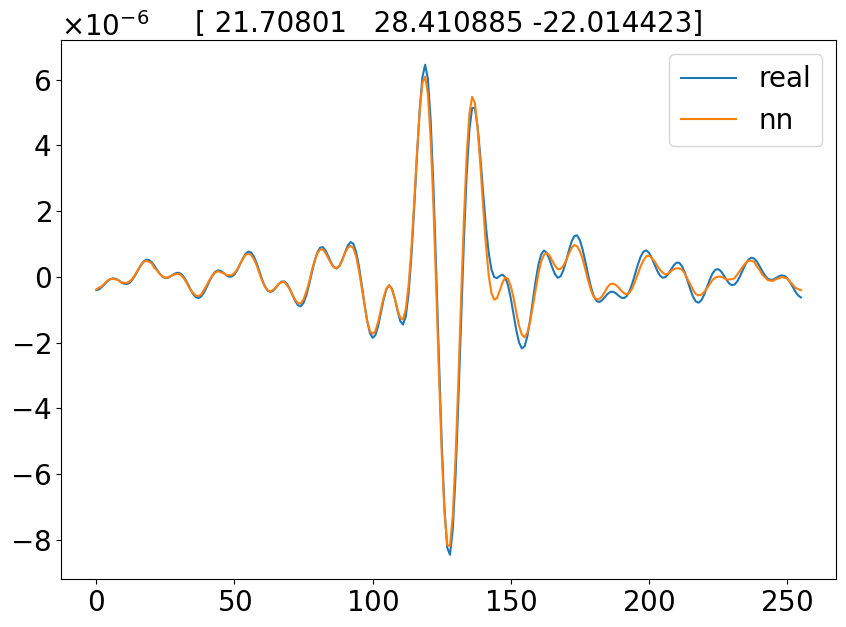

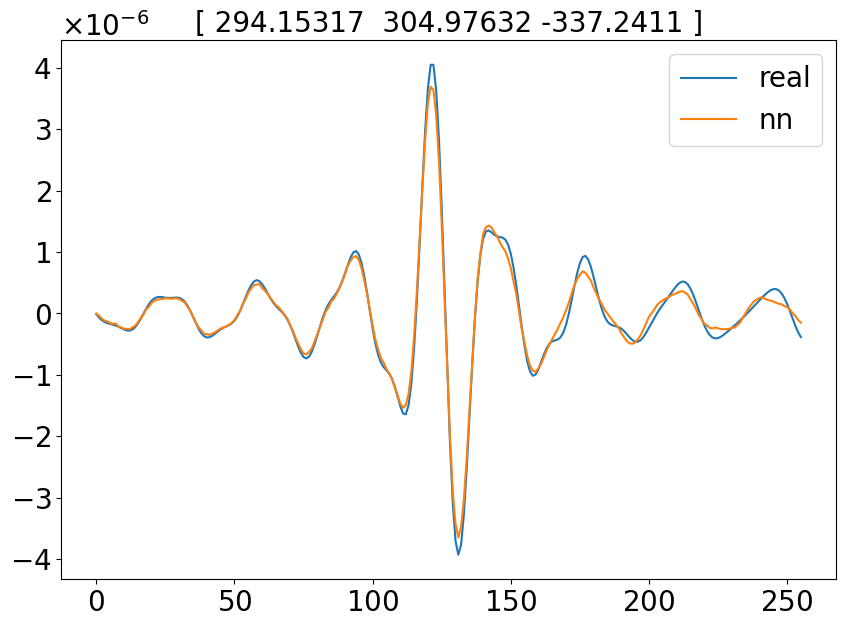

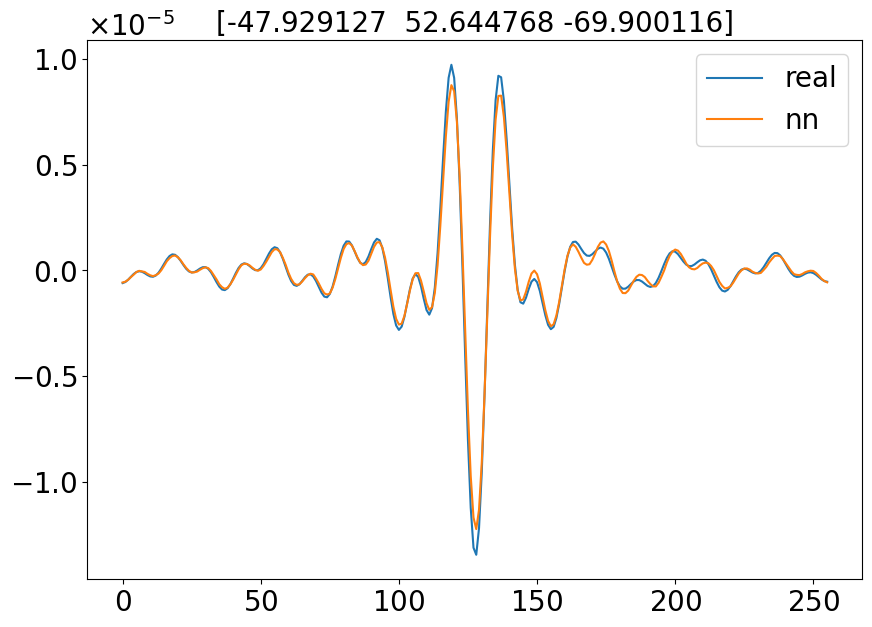

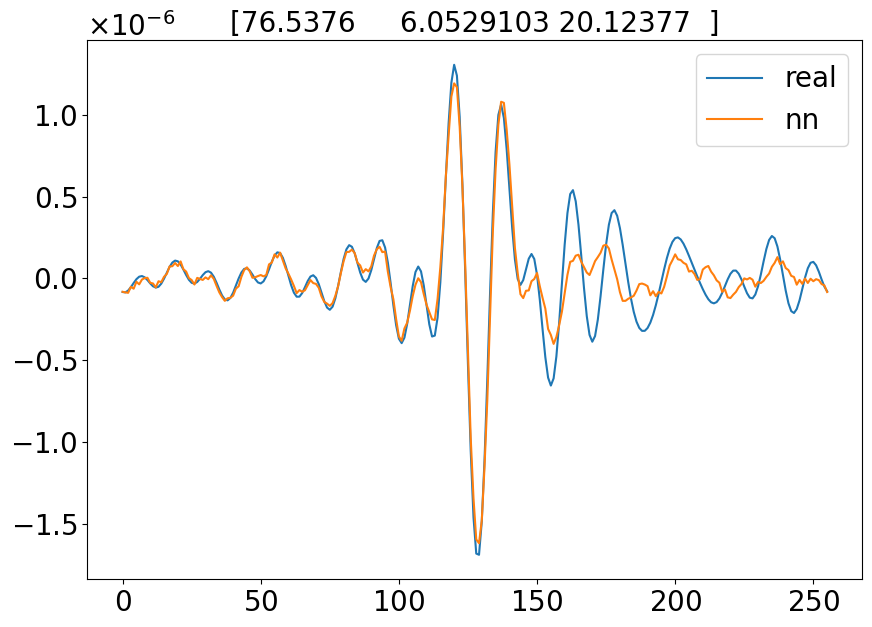

In [37]:
for _ in range(10):
    index = np.random.choice(np.argwhere(thin_or_not(real, pos, meta) > 0).flatten())
    plt.figure(figsize=(10, 7))
    plt.plot(real[index, :, 1], label='real')
    plt.plot(sim[index,:,1], label='nn')
    plt.legend()
    plt.title(pos[index])
    plt.show()

In [38]:
np.argwhere(thin_or_not(real, pos, meta) > 0).flatten()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 130,
       131, 132, 133, 136, 137, 138, 139, 140, 141, 142, 143, 147, 148,
       149, 160, 161, 162, 163, 164, 165, 166, 167, 192, 193, 194, 195,
       196, 197, 198, 199, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239])